In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [2]:
# Load the dataset.
iris = load_iris()
X = iris.data
Y = iris.target

# Split in training and testing data.
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, shuffle=True)

# Normalize the data, based on the training set.
X_train_mean = np.mean(X_train, axis=0)
X_train_std = np.std(X_train, axis= 0)
X_train = (X_train - X_train_mean) / X_train_std

# Also normalize the test set.
X_test = (X_test - X_train_mean) / X_train_std

# Save copies of the data to use with the Scikit-learn implementation.
ori_X_train = X_train.copy()
ori_X_test = X_test.copy()
ori_Y_train = Y_train.copy()
ori_Y_test = Y_test.copy()

print(f"Shape of feature matrix (X): {X.shape}")
print(f"Shape of target matrix (Y): {Y.shape}")

Shape of feature matrix (X): (150, 4)
Shape of target matrix (Y): (150,)


In [3]:
# Add a column to the feature matrix for the bias terms.
X_train = np.hstack([np.ones((X_train.shape[0], 1)), X_train])
X_test = np.hstack([np.ones((X_test.shape[0], 1)), X_test])

In [4]:
# One hot encoding for the targets.
Y_train = np.eye(np.max(Y_train) + 1)[Y_train]
Y_test = np.eye(np.max(Y_test) + 1)[Y_test]

Features matrix $X$:

$$
X \, (n \times d)=
\begin{bmatrix}
x_{1}^{T} \\
x_{2}^{T} \\
\vdots \\
x_{n}^{T}
\end{bmatrix}
,\ x_{i}\, (d \times 1)
$$

Targets matrix $Y$:

$$
Y \, (n \times t)=
\begin{bmatrix}
y_{1}^{T} \\
y_{2}^{T} \\
\vdots \\
y_{n}^{T}
\end{bmatrix}
,\ y_{i}\, (t \times 1)
$$

Parameters matrix: $W \, (d \times t)$

The model's prediction on each target is stored in matrix $Z$:

$$
Z \, (n \times t)=
\begin{bmatrix}
z_{1}^{T} \\
z_{2}^{T} \\
\vdots \\
z_{n}^{T}
\end{bmatrix}
,\ z_{i}\, (t \times 1)
$$

$$
where,\ z_{i} = softmax(W^{T}x_{i})
$$

The targets given the features and the parameters follow a <b>Categorical</b> distribution.

$$
Cat(x \mid \theta) = \prod_{j=1}^{C} \theta_{j}^{x_{i}}
$$

<b>Maximize</b> the likelihood:

$$
\begin{split}
P(Y \mid X, W) &= \prod_{i=1}^{n} p(y_{n} \mid x_{n}, W) \\
&= \prod_{i=1}^n \prod_{j=1}^{t} z_{ij}^{y_{ij}}
\end{split}
$$

This is equivalent to <b>maximizing</b> the log likelihood:

$$
\log P(Y \mid X, W) = \sum_{i=1}^{n} \sum_{j=1}^{t} y_{ij} \log z_{ij} \\
$$

Which is equivalent to <b>minimizing</b> the negative log likelihood (NLL):

$$
-\log P(Y \mid X, W) = -\sum_{i=1}^{n} \sum_{j=1}^{t} y_{ij} \log z_{ij} \\
$$

Minimizing the NLL is equivalent to minimizing the <b>Cross Entropy</b>.

We can express the NLL in matrix form as:

$$
-trace \lbrace{Y \log Z^T}\rbrace
$$

We need to derive the <b>gradient</b> of the NLL w.r.t. the parameters $W$.<br>
We will start by unfolding the softmax operation:

$$
\begin{split}
NLL &= -\sum_{i=1}^{n} \sum_{j=1}^{t} y_{ij} \log \left( \frac {\exp( W_{j}^{T} x_{i} )} {\sum_{j^{'}=1}^{t} \exp( W_{j^{'}}^{T} x_{i} )} \right) \\
&= -\sum_{i=1}^{n} \sum_{j=1}^{t} \left[ y_{ij} \sum_{k=1}^{d} x_{ik}W_{kj} - y_{ij} \log \left( \sum_{j^{'}=1}^{t} \exp(\sum_{k=1}^{d} x_{ik}W_{kj^{'}}) \right) \right]
\end{split}
$$

Derive the gradient of the NLL w.r.t. a parameter $W_{ef}$ .<br>
For each term of the (double) sum:

$$
\begin{equation}
\nabla_{W_{ef}} \left[ y_{ij} \sum_{k=1}^{d} x_{ik}W_{kj} \right] =
\begin{cases}
y_{if} x_{ie} ,\ \text{if } j=f \\
0 ,\ otherwise
\end{cases}
\end{equation}
$$

$$
\nabla_{W_{ef}} \left[ y_{ij} \log \left( \sum_{j^{'}=1}^{t} \exp(\sum_{k=1}^{d} x_{ik}W_{kj^{'}}) \right) \right] = y_{ij} z_{if} x_{ie}
$$

So, the NLL is:

$$
\begin{split}
\nabla_{W_{ef}} NLL &= -\sum_{i=1}^{n} \sum_{j=1}^{t} y_{ij} x_{ie} \left( [j=f] - z_{if} \right) \\
&= -\sum_{i=1}^{n} \left( y_{if} x_{ie} (1-z_{if}) - \sum_{j \neq f} y_{ij} x_{ie} z_{if} \right) \\
&= -\sum_{i=1}^{n} x_{ie} (y_{if} - z_{if})
\end{split}
$$

Which can be expressed in matrix from as:

$$
-X_{e}^{T} (Y_{f} - Z_{f})
$$

$$
\text{where, } A_{m} \, \text{the } m \, \text{'th column of matrix} \, A
$$

From this we can also derive the gradient w.r.t. parameters $W_{f}$ :

$$
\nabla_{W_{f}} = -X^{T} (Y_{f} - Z_{f})
$$

And the gradient w.r.t. parameters $W$ :

$$
\nabla_{W_{f}} = -X^{T} (Y - Z)
$$

<h3> <b> Stochastic gradient descent solution

In [5]:
def get_batches_of_ixs(num_of_obs, batch_size):

    shuffled_ixs = np.arange(0, num_of_obs, 1)
    np.random.shuffle(shuffled_ixs)

    batches_lims = np.arange(0, num_of_obs, batch_size)
    batches_lims = np.append(batches_lims,num_of_obs)

    batches = []

    for i in range(batches_lims.shape[0] - 1):

        start = batches_lims[i]
        end = batches_lims[i+1]
        batches.append(shuffled_ixs[start:end])

    return batches, batches_lims

def softmax(x):

    return np.exp(x) / np.sum(np.exp(x), axis=1, keepdims=True)

def compute_loss(X, Y, W):

    Z = softmax(X @ W)

    return -np.trace(Y @ np.log(Z).T)

def compute_gradient(X, Y, W):

    Z = softmax(X @ W)

    return -X.T @ (Y - Z)

def compute_score(X, Y, W):

    Z = softmax(X @ W)
    is_correct = np.argmax(Y, axis=1) == np.argmax(Z, axis=1)
    acc = np.sum(is_correct) / is_correct.shape[0]
    
    return acc

def train_with_sgd(X, Y, lr, epochs, batch_size):

    W = np.random.rand(X.shape[1], Y.shape[1])
    training_loss = []

    for i in range(epochs):

        batches_ixs, batches_lims = get_batches_of_ixs(X.shape[0], batch_size)
        epoch_loss = 0

        print(f"-------- EPOCH {i+1} --------")

        for j in range(len(batches_ixs)):

            batch_X = X[batches_ixs[j]]
            batch_Y = Y[batches_ixs[j]]
           
            grad = compute_gradient(batch_X, batch_Y, W)
            W -= lr * grad
            
            print(f"BATCH {j+1} ({batches_lims[j+1]}/{X.shape[0]}) ...")

        epoch_loss = compute_loss(X, Y, W)
        training_loss.append(epoch_loss)

        print(f"TRAINING LOSS FOR EPOCH {i+1} = {epoch_loss}")
        print(f"TRAINING SCORE FOR EPOCH {i+1} = {compute_score(X, Y, W)}")

    return W, training_loss

In [6]:
W, training_loss = train_with_sgd(X_train, Y_train, 0.05, 10, 32)

-------- EPOCH 1 --------
BATCH 1 (32/120) ...
BATCH 2 (64/120) ...
BATCH 3 (96/120) ...
BATCH 4 (120/120) ...
TRAINING LOSS FOR EPOCH 1 = 40.78423275543925
TRAINING SCORE FOR EPOCH 1 = 0.8916666666666667
-------- EPOCH 2 --------
BATCH 1 (32/120) ...
BATCH 2 (64/120) ...
BATCH 3 (96/120) ...
BATCH 4 (120/120) ...
TRAINING LOSS FOR EPOCH 2 = 35.62231080391246
TRAINING SCORE FOR EPOCH 2 = 0.8666666666666667
-------- EPOCH 3 --------
BATCH 1 (32/120) ...
BATCH 2 (64/120) ...
BATCH 3 (96/120) ...
BATCH 4 (120/120) ...
TRAINING LOSS FOR EPOCH 3 = 30.445948206797674
TRAINING SCORE FOR EPOCH 3 = 0.9166666666666666
-------- EPOCH 4 --------
BATCH 1 (32/120) ...
BATCH 2 (64/120) ...
BATCH 3 (96/120) ...
BATCH 4 (120/120) ...
TRAINING LOSS FOR EPOCH 4 = 27.49748951932897
TRAINING SCORE FOR EPOCH 4 = 0.9333333333333333
-------- EPOCH 5 --------
BATCH 1 (32/120) ...
BATCH 2 (64/120) ...
BATCH 3 (96/120) ...
BATCH 4 (120/120) ...
TRAINING LOSS FOR EPOCH 5 = 25.03619977943267
TRAINING SCORE FOR EPO

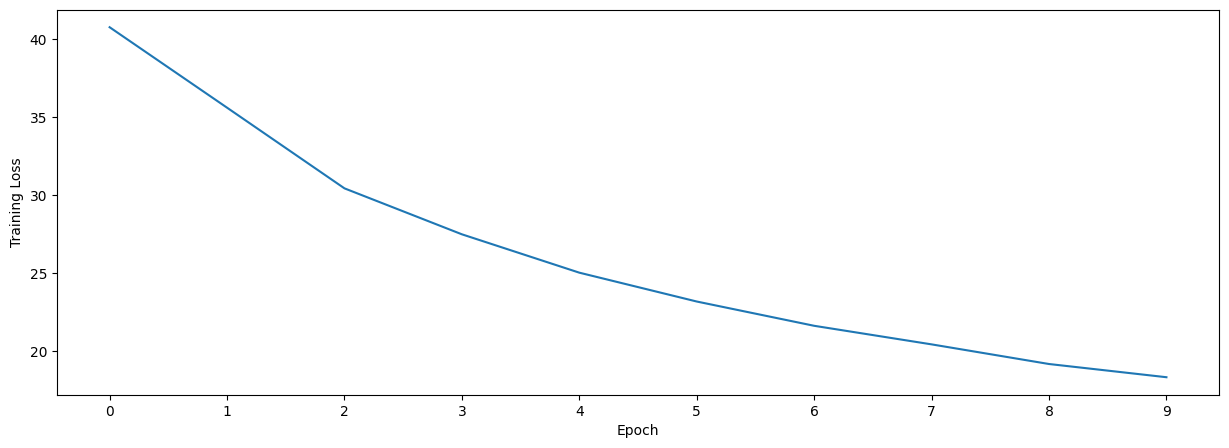

In [7]:
epochs = list(range(len(training_loss)))

fig, ax = plt.subplots(figsize=(15, 5))

ax.plot(training_loss)
ax.set_xlabel("Epoch")
ax.set_ylabel("Training Loss")
ax.set_xticks(epochs)

plt.show()

In [8]:
# Get the model's accuracy on the training data.
compute_score(X_train, Y_train, W)

0.9666666666666667

In [9]:
# Get the model's accuracy on the testing data.
compute_score(X_test, Y_test, W)

1.0

<h3> <b> Scikit-learn solution

In [10]:
logreg = LogisticRegression()
logreg.fit(ori_X_train, ori_Y_train)

LogisticRegression()

In [11]:
logreg.score(ori_X_train, ori_Y_train)

0.975

In [12]:
logreg.score(ori_X_test, ori_Y_test)

1.0